In [116]:
from google.colab import drive
drive.mount('/content/drive')

Drive already mounted at /content/drive; to attempt to forcibly remount, call drive.mount("/content/drive", force_remount=True).


# libraries

In [117]:
import tensorflow as tf
import pandas as pd
import matplotlib.pyplot as plt
from keras.preprocessing.image import load_img,img_to_array
from keras.layers import Conv2D,UpSampling2D,Conv2DTranspose,MaxPooling2D,Input,Dense,Flatten,Dropout,BatchNormalization,Activation,MaxPool2D
from keras.optimizers import Adam,SGD,Adagrad,Adadelta
from keras.models import Sequential,Model
import os


In [118]:
root_dir='/content/drive/MyDrive/art_dataset/'

In [119]:
img_path=os.listdir(root_dir)
len(img_path)

162

# preprocessing

In [120]:
images=[]
for img_path in img_path:
  img=load_img(root_dir+img_path,target_size=(64,64),color_mode='grayscale')
  img=img_to_array(img)
  img=img/255.
  images.append(img)

In [121]:
import numpy as np
images=np.array(images)

In [122]:
type(images)

numpy.ndarray

# data visualization

In [123]:
def visualize_df(df:np.ndarray):
  fig, axes = plt.subplots(4, 4)
  for i, ax in enumerate(axes.ravel()):
    if i < len(df):
      img = df[i]
      ax.imshow(img,cmap='gray')
      ax.axis("off")
    else:
      ax.axis("off")
  plt.tight_layout()
  plt.show()

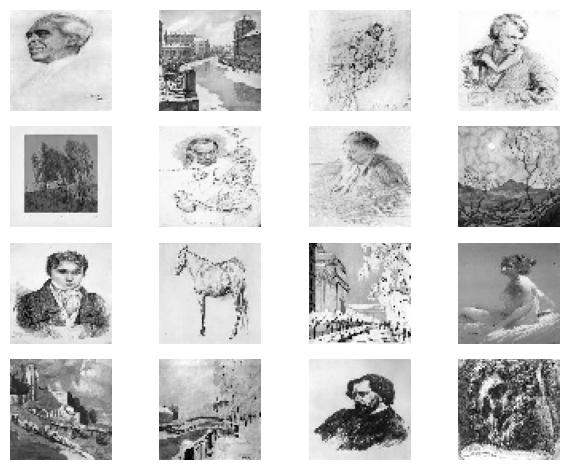

In [124]:
visualize_df(images)

# adding noise

In [181]:
noise_factor=0.5
noise_images=[]
for image in images:
  noisy=image+noise_factor*np.random.randn(*image.shape)
  noisy=np.clip(noisy,0.,1.)
  noise_images.append(noisy)

In [182]:
noise_images=np.array(noise_images)

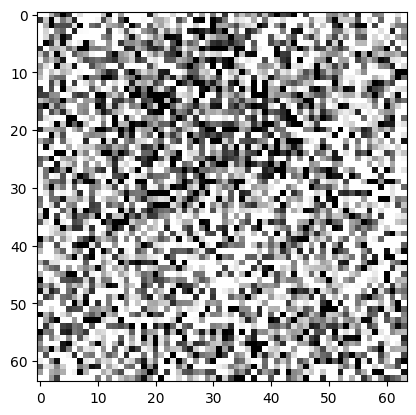

In [183]:
plt.imshow(noise_images[0],cmap='gray')

# spliting data

In [184]:
noise_train=noise_images[:100]
noise_test=noise_images[100:]
normal_train=images[:100]
normal_test=images[100:]
noise_train.shape,noise_test.shape


((100, 64, 64, 1), (62, 64, 64, 1))

# Model

In [194]:
def autoencoder():
  input_img=Input(shape=(64,64,1),name="img_input")
  #encoder
  x=Conv2D(128,(3,3),activation='relu',padding='same',name='conv1')(input_img)

  x=MaxPooling2D((2,2),padding='same',name='pool1')(x)
  x=Conv2D(256,(3,3),activation='relu',padding='same',name='conv2')(x)
  x=Dropout(0.3)(x)


  x=Conv2D(128,(3,3),activation='relu',padding='same',name='conv3')(x)
  x=BatchNormalization()(x)
  x=Activation('relu')(x)
  encoded=MaxPooling2D((2,2),padding='same',name='pool3')(x)
  #decoder
  x=Conv2D(32,(3,3),activation='relu',padding='same',name='conv4')(encoded)
  x=UpSampling2D((2,2),name='upsample1')(x)
  x=Conv2D(16,(3,3),activation='relu',padding='same',name='conv5')(x)
  x=UpSampling2D((2,2),name='upsample2')(x)
  decoded=Conv2D(1,(3,3),activation='sigmoid',padding='same',name='conv7')(x)


  autoencoder=Model(inputs=input_img,outputs=decoded)
  autoencoder.compile(optimizer='Adam',loss='mse')
  return autoencoder

In [ ]:
def autoencoder2():
  encoder_input=Input(shape=normal_train.shape[1:])
  x=Conv2D(64,(3,3),activation='relu',padding='same')(encoder_input)
  x=BatchNormalization()(x)
  x=MaxPool2D((2,2),padding='same')(x)

  x=Conv2D(32,(3,3),activation='relu',padding='same')(x)
  x=BatchNormalization()(x)
  encoded=MaxPool2D((2,2),padding='same')(x)


  #decoder
  x=Conv2D(32,(3,3),activation='relu',padding='same')(encoded)
  x=BatchNormalization()(x)
  x=UpSampling2D()(x)

  x=Conv2D(64,(3,3),activation='relu',padding='same')(x)
  x=BatchNormalization()(x)
  x=UpSampling2D()(x)
  decoded=Conv2D(1,(3,3),activation='sigmoid',padding='same')(x)

  autoencoder2=Model(inputs=encoder_input,outputs=decoded)
  autoencoder2.compile(optimizer='Adam',loss='mean_squared_error')
  return autoencoder2



In [195]:
model=autoencoder()
model.summary()

Model: "model_23"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 img_input (InputLayer)      [(None, 64, 64, 1)]       0         
                                                                 
 conv1 (Conv2D)              (None, 64, 64, 128)       1280      
                                                                 
 pool1 (MaxPooling2D)        (None, 32, 32, 128)       0         
                                                                 
 conv2 (Conv2D)              (None, 32, 32, 256)       295168    
                                                                 
 dropout_18 (Dropout)        (None, 32, 32, 256)       0         
                                                                 
 conv3 (Conv2D)              (None, 32, 32, 128)       295040    
                                                                 
 batch_normalization_33 (Ba  (None, 32, 32, 128)       512

In [196]:
model.fit(noise_train,normal_train,
          validation_data=(noise_test,normal_test),
          epochs=100,
          batch_size=128)

Epoch 1/100
1/1 [==============================] - 2s 2s/step - loss: 0.1955 - val_loss: 0.0705
Epoch 2/100
1/1 [==============================] - 0s 185ms/step - loss: 0.0625 - val_loss: 0.0614
Epoch 3/100
1/1 [==============================] - 0s 144ms/step - loss: 0.0605 - val_loss: 0.0574
Epoch 4/100
1/1 [==============================] - 0s 132ms/step - loss: 0.0509 - val_loss: 0.0552
Epoch 5/100
1/1 [==============================] - 0s 132ms/step - loss: 0.0406 - val_loss: 0.0540
Epoch 6/100
1/1 [==============================] - 0s 134ms/step - loss: 0.0348 - val_loss: 0.0529
Epoch 7/100
1/1 [==============================] - 0s 132ms/step - loss: 0.0337 - val_loss: 0.0520
Epoch 8/100
1/1 [==============================] - 0s 129ms/step - loss: 0.0322 - val_loss: 0.0520
Epoch 9/100
1/1 [==============================] - 0s 131ms/step - loss: 0.0290 - val_loss: 0.0539
Epoch 10/100
1/1 [==============================] - 0s 131ms/step - loss: 0.0266 - val_loss: 0.0575
Epoch 11/100

In [197]:
predicted=model.predict(noise_test)

2/2 [==============================] - 0s 9ms/step


# loss funcation

In [198]:
from sklearn.metrics import mean_squared_error
actual_value_flat=normal_test.flatten()
predicted_value_flat=predicted.flatten()
mse=mean_squared_error(actual_value_flat,predicted_value_flat)
print(mse)

0.022122813


In [199]:
def plot_predication(test,preds):
  plt.figure(figsize=(24,24))
  for i in range(16):
    plt.subplot(4,8,i+1)
    plt.imshow(test[i],cmap='gray')
    plt.axis('off')
    plt.title('noised')

    #predicted
  for i in range(16):
    plt.subplot(4,8,i+17)
    plt.imshow(preds[i],cmap='gray')
    plt.axis('off')
    plt.title('predicted')
  plt.show()


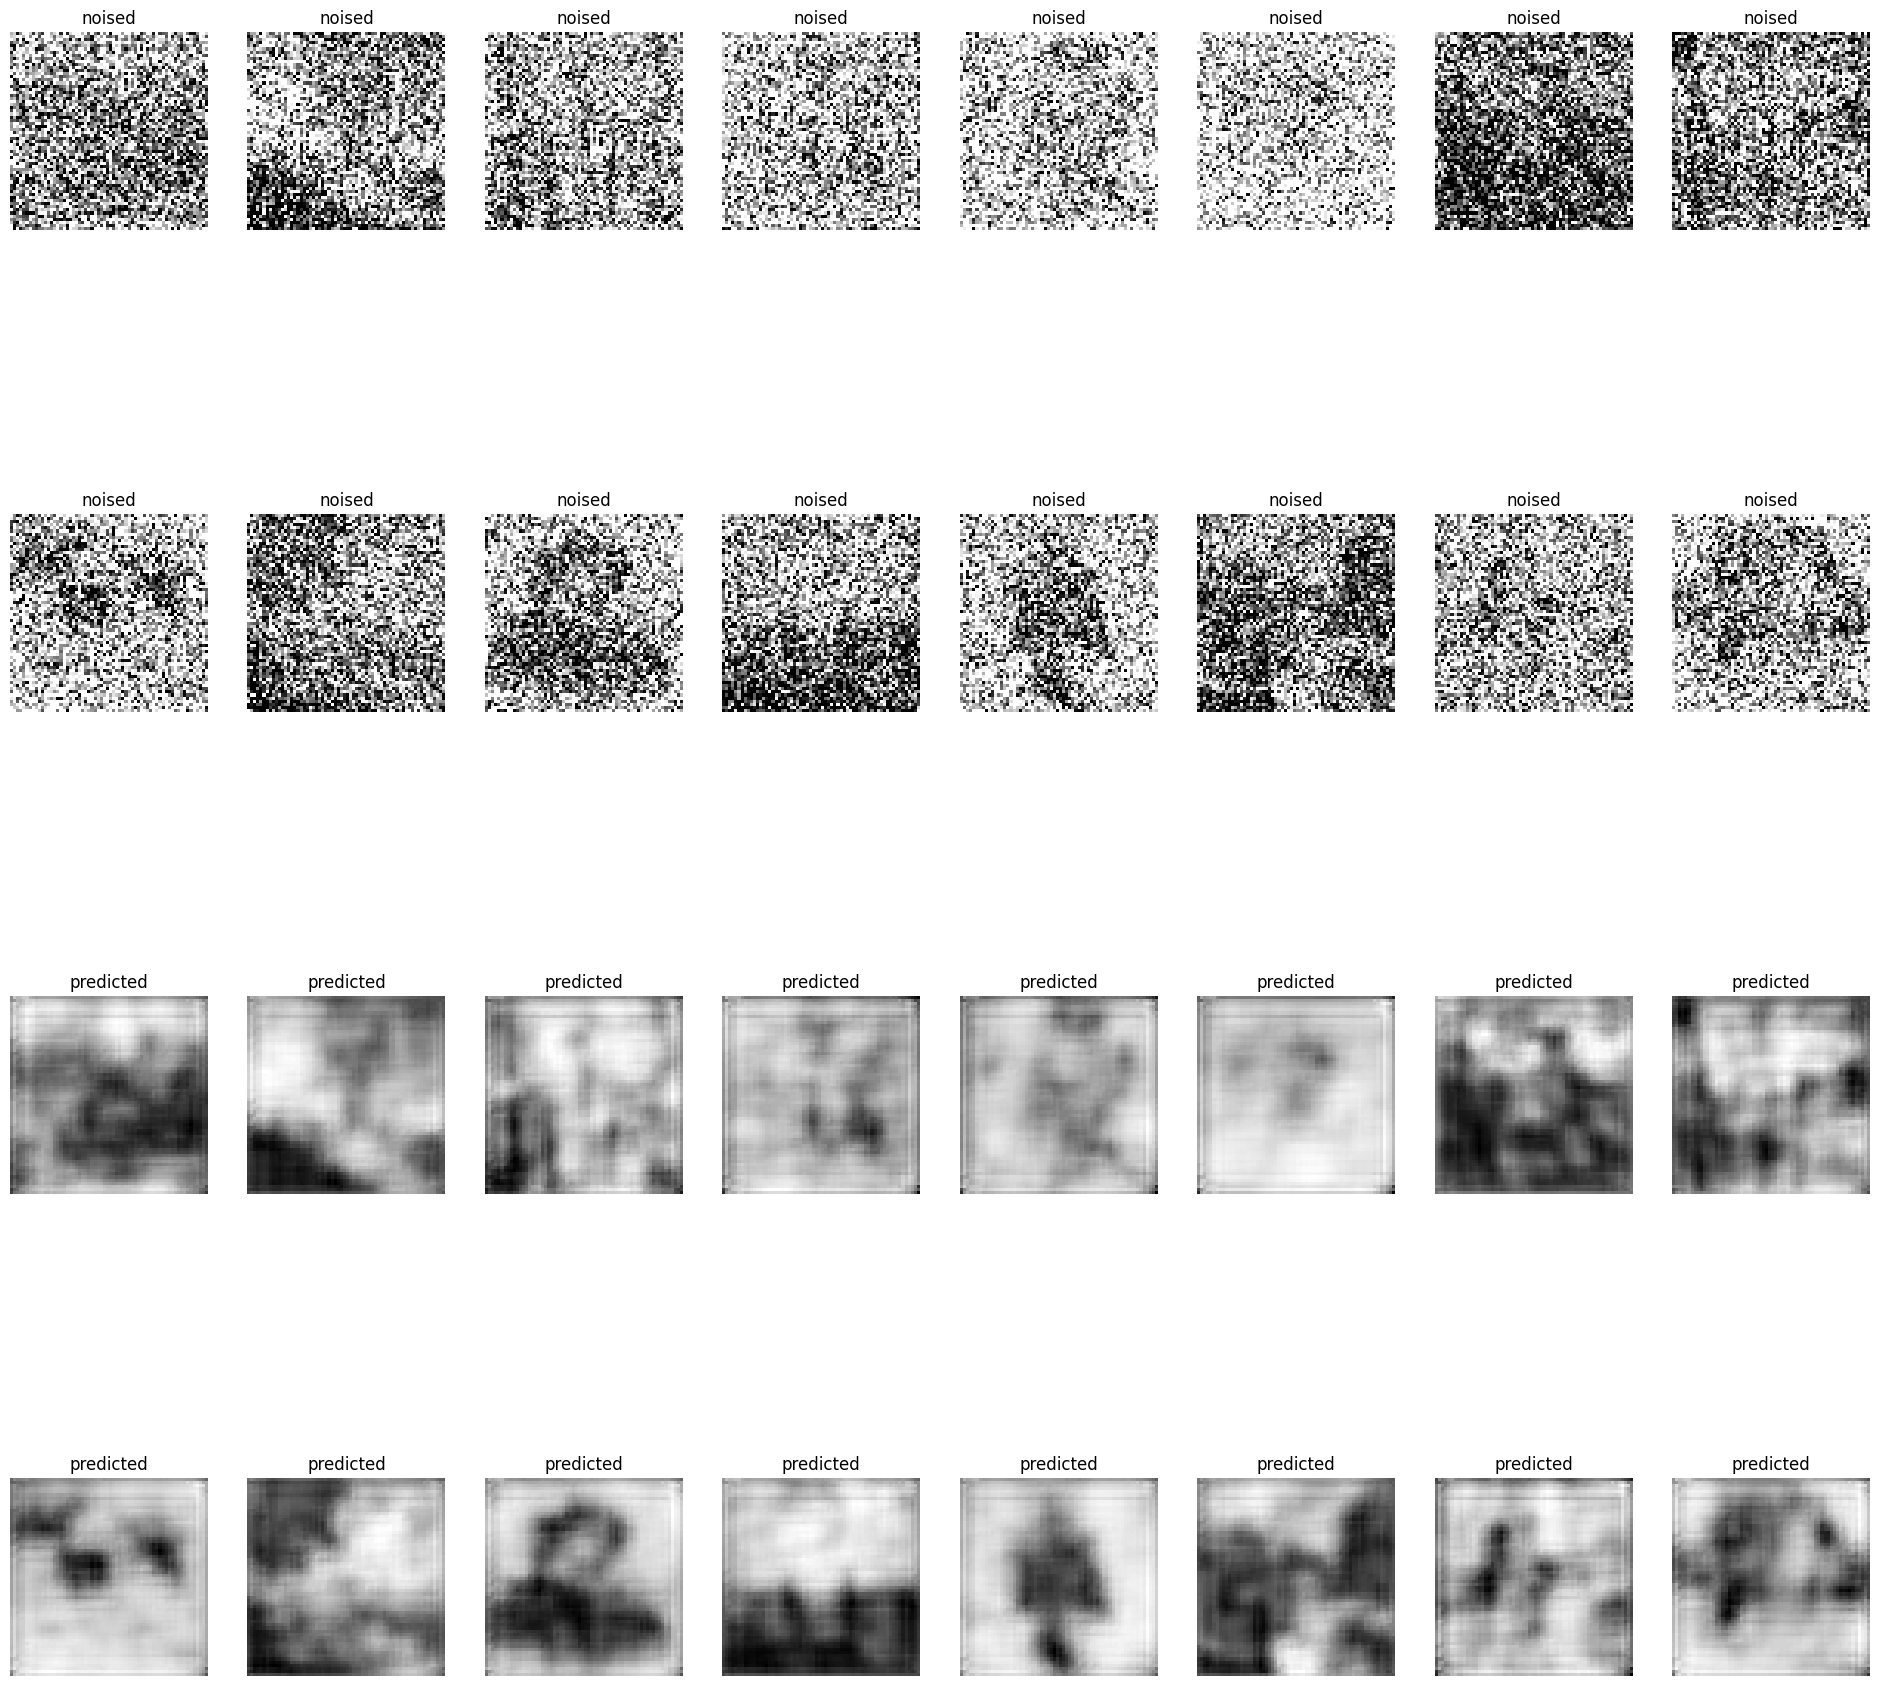

In [191]:
plot_predication(noise_test,predicted)

In [200]:
evaluation=model.evaluate(normal_test,noise_test)
evaluation

2/2 [==============================] - 0s 13ms/step - loss: 0.1310


0.1309901475906372

In [203]:
model.save('denoising.h5')

/usr/local/lib/python3.10/dist-packages/keras/src/engine/training.py:3103: UserWarning: You are saving your model as an HDF5 file via `model.save()`. This file format is considered legacy. We recommend using instead the native Keras format, e.g. `model.save('my_model.keras')`.
  saving_api.save_model(
